In [1]:
import os
import glob

# I first used this notebook with this model, which accidentally
# had a sigmoid output on the audio representations.
# model_folder = '../outputs/crepe-20211128-170108'

# Now i'm trying this one.
model_folder = '../outputs/crepe-20211128-195735'

model_paths = glob.glob(os.path.join(model_folder, '*'))

In [2]:
import sys
sys.path.append('/home/jxm3/research/transcription/contrastive-pitch-detection')

In [3]:
from models.crepe import CREPE
from models.contrastive import ContrastiveModel

min_midi = 21
max_midi = 108
def get_model():
    # TODO(jxm): support nn.DataParallel here
    num_output_nodes = 256 # contrastive embedding dim
    out_activation = None
    
    model = CREPE(
        model='tiny',
        num_output_nodes=num_output_nodes, 
        load_pretrained=False,
        out_activation=out_activation
    )
    
    return ContrastiveModel(model, min_midi, max_midi, num_output_nodes)

In [4]:
model = get_model()

In [5]:
import glob
import natsort
import os
import torch

model_paths = glob.glob(os.path.join(model_folder, '*'))

model_path = natsort.natsorted(model_paths)[-2]
print('loaded model from:', model_path)
#model.load_state_dict(torch.load(model_path)['model'])

loaded model from: ../outputs/crepe-20211128-195735/99_epochs.pth


In [6]:
# from dataloader.nsynth import load_nsynth
# dataset = load_nsynth('test', 'keyboard')

from dataloader.nsynth_chords import load_nsynth_chords
dataset = load_nsynth_chords('test')

print('loaded', len(dataset), 'tracks')

import random
random.shuffle(dataset)

loaded 39 tracks


In [7]:
import numpy as np

from utils.misc import midi_vals_to_categorical, hz_to_midi_v

batch_size = 32

min_midi = 21
max_midi = 108

x = []
y = []
all_midis = []

for i in range(batch_size):
    track = dataset[i]
    start_idx = 0
    end_idx = 16_000
    #
    audio = torch.tensor(track.waveform[start_idx : end_idx], dtype=torch.float32)
    x.append(audio)
    #
    frequencies = track.get_frequencies_from_offset(start_idx, end_idx)
    midis = np.rint(hz_to_midi_v(frequencies))
    all_midis.append(list(midis))
    categorical = midi_vals_to_categorical(midis, min_midi, max_midi)
    y.append(torch.tensor(categorical, dtype=torch.float32))
x = torch.stack(x)
y = torch.stack(y)
print('loaded audio batch of shape:', x.shape, 'with labels', y.shape)

loaded audio batch of shape: torch.Size([32, 16000]) with labels torch.Size([32, 88])


In [8]:
y.sum(1)

tensor([1., 3., 1., 1., 1., 1., 3., 1., 1., 1., 2., 2., 1., 1., 2., 1., 2., 2.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.])

In [ ]:
from IPython.display import Audio
Audio(data=x[0], rate=16000)

In [ ]:
all_midis_str = [str(m) for m in all_midis]
print(len(all_midis_str))
print(len(set(all_midis_str)))

32
28


In [ ]:
audio_embeddings = model(x)
note_labels = y

#### Taken from ContrastiveModel.contrastive_loss() ####
batch_size, num_notes = note_labels.shape
assert num_notes == model.num_labels
chord_embeddings = note_labels @ model.embedding.weight # [b,n] @ [n, d] -> [b, d]
# Make sure the shapes match up.
assert chord_embeddings.shape == audio_embeddings.shape
# Normalize to create embeddings.
# TODO(jxm) should I do bilinear interpolation here?
normalized_audio_embeddings = audio_embeddings / torch.norm(audio_embeddings, dim=1, keepdim=True)
normalized_chord_embeddings = chord_embeddings / torch.norm(chord_embeddings, dim=1, keepdim=True)
logits = (normalized_audio_embeddings @ normalized_chord_embeddings.T) * torch.exp(model.temperature)
# Symmetric loss function
labels = torch.diag(torch.ones(batch_size)).to(logits.device) # Identity matrix
loss_a = torch.nn.functional.binary_cross_entropy_with_logits(labels, logits)
loss_n = torch.nn.functional.binary_cross_entropy_with_logits(labels, logits.T)
####

loss = (loss_a + loss_n)/2

In [ ]:
print(loss_a, loss_n)

tensor(0.7113, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.7113, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
torch.nn.functional.binary_cross_entropy_with_logits(labels, logits+labels*1000)

tensor(-30.5387, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

<AxesSubplot:>

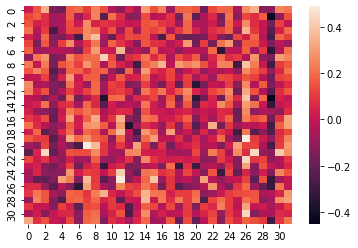

In [ ]:
import seaborn as sns
sns.heatmap(logits.detach()) # true model output (no softmax)

In [ ]:
y.sum(1)

tensor([1., 3., 1., 1., 1., 1., 3., 1., 1., 1., 2., 2., 1., 1., 2., 1., 2., 2.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.])

<AxesSubplot:>

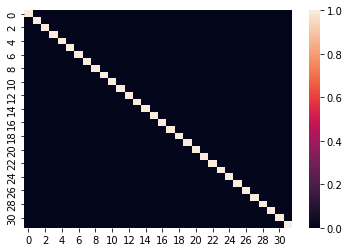

In [ ]:
import seaborn as sns
sns.heatmap(labels.detach()) # desired output

<AxesSubplot:>

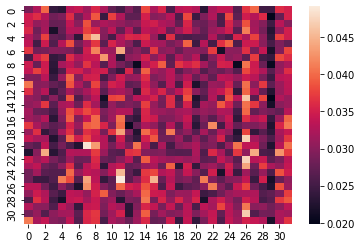

In [ ]:
import seaborn as sns
sns.heatmap(torch.nn.functional.softmax(logits.detach(), 1)) # true model output (with softmax over dim 1)

<AxesSubplot:>

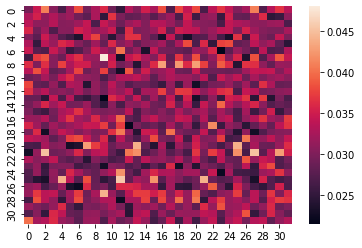

In [ ]:
import seaborn as sns
sns.heatmap(torch.nn.functional.softmax(logits.detach(), 0)) # true model output (with softmax over dim 0)

In [ ]:
1/32

0.03125

<AxesSubplot:>

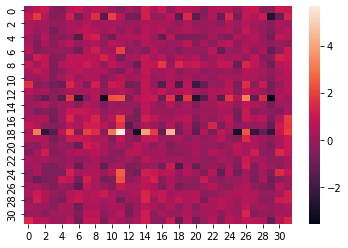

In [ ]:
unnorm_logits = (audio_embeddings @ chord_embeddings.T) * torch.exp(model.temperature)
import seaborn as sns
sns.heatmap(unnorm_logits.detach()) # true model output

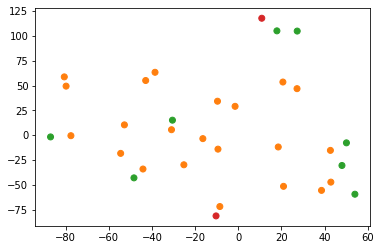

In [ ]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(chord_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(num_notes):
    emb_colors.append(colors[round(y[i].sum().item())])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Chord embeddings colored by number of notes.

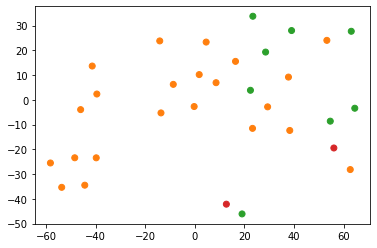

In [ ]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(audio_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(num_notes):
    emb_colors.append(colors[round(y[i].sum().item())])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Audio embeddings colored by number of notes.

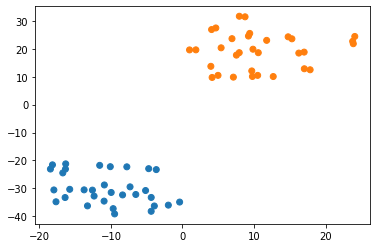

In [ ]:
import sklearn
import matplotlib.pyplot as plt

all_embeddings = torch.cat([audio_embeddings, chord_embeddings]).detach()
num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(all_embeddings)
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(len(all_embeddings)):
    ci = 0 if i < num_notes else 1 # make chord and audio embeddings different colors
    emb_colors.append(colors[ci])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Audio vs. chord embeddings. (audio are blue)

In [ ]:
torch.cat([audio_embeddings, chord_embeddings]).shape

torch.Size([64, 256])

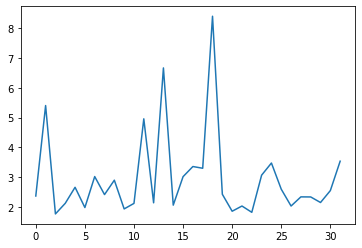

In [ ]:
plt.plot(torch.norm(audio_embeddings, p=2, dim=1).detach())

In [ ]:
audio_embeddings.min()

tensor(-1.7423, grad_fn=<MinBackward1>)

In [ ]:
chord_embeddings[0]

tensor([ 0.0919,  0.0217, -0.0669,  0.0926,  0.0186, -0.1178, -0.0353, -0.0917,
        -0.0108, -0.0534,  0.0415, -0.1025, -0.0800, -0.0763, -0.0405,  0.0023,
        -0.1041, -0.0251, -0.0747,  0.0213, -0.1163,  0.1210, -0.0727, -0.0905,
         0.0523,  0.0046,  0.0818,  0.0165,  0.0572,  0.0821, -0.0779,  0.0724,
        -0.0307,  0.0569, -0.0460,  0.1088,  0.0610, -0.0693,  0.0436, -0.1201,
         0.0063, -0.0836,  0.1171,  0.0472,  0.0426,  0.0187,  0.1306,  0.0196,
         0.0790, -0.0135,  0.1143, -0.0904,  0.0127,  0.0673, -0.0610,  0.0442,
         0.1185, -0.0745,  0.1230, -0.0258, -0.0079, -0.1295,  0.1024,  0.0263,
         0.0560, -0.0289, -0.0277, -0.0227, -0.0336, -0.0116,  0.0718,  0.0970,
        -0.0478, -0.0812, -0.0959, -0.1281,  0.1020, -0.1257,  0.0998,  0.1121,
        -0.0497,  0.0631, -0.0945,  0.0622, -0.0881, -0.0283,  0.0161,  0.0281,
        -0.0695, -0.0939, -0.0133,  0.0832,  0.1003, -0.0019,  0.0304,  0.0916,
        -0.0153, -0.1147, -0.0730, -0.06

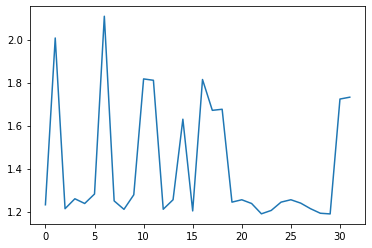

In [ ]:
plt.plot(torch.norm(chord_embeddings, p=2, dim=1).detach()) # these r way smaller, 
                                    # and clearly have magnitude proportional to the number of notes in the chord...

In [ ]:
audio_embeddings.max()

tensor(1.4067, grad_fn=<MaxBackward1>)

In [ ]:
audio_embeddings.min()

tensor(-1.7423, grad_fn=<MinBackward1>)

In [ ]:
chord_embeddings.max()

tensor(0.3596, grad_fn=<MaxBackward1>)

In [ ]:
chord_embeddings.min()

tensor(-0.3476, grad_fn=<MinBackward1>)

In [ ]:
A = torch.zeros((10,10))

In [ ]:
torch.nn.init.xavier_uniform_(A)

tensor([[ 0.5061, -0.0950, -0.2718, -0.1925,  0.5060, -0.5004, -0.2746,  0.1795,
         -0.1603,  0.1738],
        [-0.1495,  0.5017,  0.1477, -0.0577, -0.1932, -0.1816, -0.0691,  0.4471,
         -0.4121,  0.5464],
        [-0.4907,  0.2149, -0.3108, -0.0813, -0.0028,  0.5051,  0.1300, -0.3199,
          0.2622, -0.4568],
        [-0.1697, -0.4338, -0.5450,  0.0500, -0.1087,  0.0770, -0.1273,  0.0658,
         -0.1240,  0.3243],
        [-0.4927, -0.1594,  0.1844, -0.5193, -0.0323, -0.3565,  0.1569, -0.4696,
         -0.2971, -0.2539],
        [ 0.3105,  0.4474, -0.2641,  0.0950, -0.4222,  0.4201,  0.1828, -0.1744,
          0.1193, -0.3209],
        [-0.2286,  0.5320,  0.1628, -0.2710,  0.3396,  0.0601, -0.0359,  0.2039,
         -0.5000, -0.3227],
        [ 0.1004,  0.5027,  0.5347,  0.3262,  0.4541, -0.0779, -0.1101, -0.1558,
          0.3480,  0.1895],
        [ 0.1332,  0.0409, -0.0930,  0.2097, -0.0962, -0.5228, -0.3614, -0.1378,
         -0.2082,  0.3332],
        [-0.1117, -

In [ ]:
A.max()

tensor(0.5464)

In [ ]:
# Testing to see what the output of a random linear layer is. Is it [0,1]?
x = torch.nn.Linear(in_features=360, out_features=10)
x(torch.randn((16,360)))

tensor([[-0.1514, -0.7801, -0.2494,  0.0304,  0.0133, -0.1304, -0.3532, -1.0974,
          0.1254, -0.2039],
        [ 0.5877,  0.5051,  1.4456,  0.0367, -0.4204,  0.5097,  0.9427,  0.4079,
         -0.4046, -0.3590],
        [-0.1274, -0.3404,  0.5032, -0.1102,  0.4700,  0.7777,  0.5852, -1.1403,
         -0.1229, -0.2673],
        [ 0.3754, -1.1885, -0.6937,  0.6860,  1.4446,  0.9362,  0.5225, -0.6102,
         -0.5597, -0.5459],
        [-0.2912, -0.4557, -1.3044,  0.1179,  0.8301,  0.4493, -0.2171, -0.9155,
          0.7442, -0.6753],
        [ 0.6889,  1.0138, -1.0732, -0.0356,  0.7812,  0.8980, -0.1535,  0.5079,
          0.5959,  0.7031],
        [-0.0529, -0.7489, -0.7285, -0.0301, -0.8707, -0.5774, -0.6219,  0.5112,
          0.3573, -0.1273],
        [-1.4882, -0.1691, -0.1372, -0.1067, -0.2413, -0.9271,  0.9202, -0.7589,
         -0.2059, -0.1226],
        [ 0.0304, -1.0426, -1.4238, -0.0912,  0.2851, -0.0077, -0.8738, -0.3773,
          0.3137,  0.6002],
        [ 0.2893, -

<AxesSubplot:ylabel='Count'>

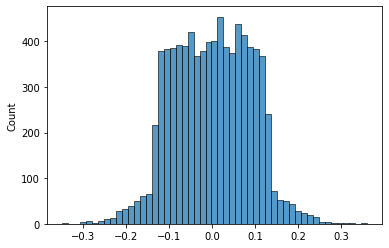

In [ ]:
sns.histplot(chord_embeddings.flatten().detach())

<AxesSubplot:ylabel='Count'>

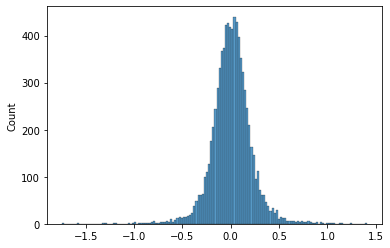

In [ ]:
sns.histplot(audio_embeddings.flatten().detach())

In [ ]:
import functools
softmax = functools.partial(torch.nn.functional.softmax, dim=1)

In [ ]:
chord_embeddings[0]

tensor([ 0.0919,  0.0217, -0.0669,  0.0926,  0.0186, -0.1178, -0.0353, -0.0917,
        -0.0108, -0.0534,  0.0415, -0.1025, -0.0800, -0.0763, -0.0405,  0.0023,
        -0.1041, -0.0251, -0.0747,  0.0213, -0.1163,  0.1210, -0.0727, -0.0905,
         0.0523,  0.0046,  0.0818,  0.0165,  0.0572,  0.0821, -0.0779,  0.0724,
        -0.0307,  0.0569, -0.0460,  0.1088,  0.0610, -0.0693,  0.0436, -0.1201,
         0.0063, -0.0836,  0.1171,  0.0472,  0.0426,  0.0187,  0.1306,  0.0196,
         0.0790, -0.0135,  0.1143, -0.0904,  0.0127,  0.0673, -0.0610,  0.0442,
         0.1185, -0.0745,  0.1230, -0.0258, -0.0079, -0.1295,  0.1024,  0.0263,
         0.0560, -0.0289, -0.0277, -0.0227, -0.0336, -0.0116,  0.0718,  0.0970,
        -0.0478, -0.0812, -0.0959, -0.1281,  0.1020, -0.1257,  0.0998,  0.1121,
        -0.0497,  0.0631, -0.0945,  0.0622, -0.0881, -0.0283,  0.0161,  0.0281,
        -0.0695, -0.0939, -0.0133,  0.0832,  0.1003, -0.0019,  0.0304,  0.0916,
        -0.0153, -0.1147, -0.0730, -0.06

In [ ]:
audio_embeddings[0]

tensor([-0.0512, -0.1722,  0.0103, -0.0422,  0.0957,  0.3627,  0.0556, -0.0301,
         0.2714,  0.2035, -0.1407,  0.1300, -0.2419,  0.3691, -0.3291,  0.3473,
        -0.0888, -0.1618,  0.1784,  0.0020, -0.1537, -0.0487, -0.2193, -0.0673,
         0.0932, -0.1447,  0.0622,  0.1651,  0.0760,  0.0709,  0.0457,  0.0092,
        -0.1169,  0.0269, -0.2848, -0.1218, -0.1292,  0.0152,  0.2236,  0.0300,
         0.0179,  0.1597, -0.1150, -0.0134,  0.1881, -0.1886, -0.1215,  0.1041,
        -0.0699, -0.0258,  0.1551,  0.2518,  0.1147,  0.0513, -0.0513,  0.0906,
         0.0775, -0.3631, -0.0298,  0.0266, -0.1977,  0.1091, -0.2377, -0.0789,
         0.0942, -0.0149,  0.0423, -0.0269,  0.0104, -0.2064,  0.0626, -0.0194,
         0.0564,  0.1363, -0.0297, -0.2407, -0.0644,  0.1585, -0.0929, -0.1143,
         0.0096, -0.4793, -0.1447,  0.0674, -0.0176,  0.1321,  0.1515,  0.0330,
         0.1020, -0.0110, -0.1053, -0.1863,  0.1194,  0.0159,  0.0876, -0.0735,
         0.0928,  0.1720,  0.1793, -0.17

In [ ]:
cos_sim = torch.nn.CosineSimilarity(dim=1)
torch.unsqueeze(cos_sim(audio_embeddings[14], chord_embeddings), 0)

tensor([[ 0.0048,  0.0160,  0.0770, -0.0409,  0.0235,  0.0329, -0.0245,  0.0688,
          0.0227, -0.0868,  0.0104, -0.0175, -0.0081, -0.0207,  0.0804,  0.0120,
         -0.0200,  0.0688, -0.0372,  0.0594, -0.0878,  0.0235,  0.0101,  0.0968,
          0.0594, -0.0207,  0.1102,  0.0770,  0.0014, -0.1203,  0.0012,  0.0138]],
       grad_fn=<UnsqueezeBackward0>)

In [ ]:
# What is the loss for uniform logits?

logits = torch.ones((batch_size, batch_size), dtype=torch.float32) * 3000
# Symmetric loss function
labels = torch.diag(torch.ones(batch_size)).to(logits.device) # Identity matrix
loss_a = torch.nn.functional.binary_cross_entropy_with_logits(labels, logits)
loss_n = torch.nn.functional.binary_cross_entropy_with_logits(labels, logits.T)
####

loss = (loss_a + loss_n)/2
loss

tensor(-93.0375)